# Mean-variance portfolio

## Importing the packages

In [54]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
matplotlib.style.use('ggplot')

## Importing the data

#### Bonds

In [55]:
bonds = pd.read_csv('bofa_ice_sovereign_bonds_returns.csv')
bonds = bonds.set_index('Unnamed: 0')
bonds.index = pd.to_datetime(bonds.index)
bonds = bonds.sort_index()
bonds = bonds.ffill().fillna(0).pct_change().fillna(0)

In [60]:
bonds = bonds.loc[bonds.index.isin(pd.date_range('2016-09-01', '2022-01-01'))]

In [12]:
names = pd.read_csv('../Data/country_data/ice_bofa_sovereign_indices_summary.csv')
new_columns = {}

for i in range(len(names)):
    new_columns[(names['Index BBG Ticker']+' Index').loc[i]] = names['Full Index Name'].apply(lambda x: x.split(' ')[4]).loc[i]

#### Equities

In [13]:
equities = pd.read_csv('../Data/country_data/ETF_adj_close.csv')
equities = equities.rename(columns={'Unnamed: 0': 'trdate'})
equities = equities.set_index('trdate')
equities.index = pd.to_datetime(equities.index)
equities = equities.sort_index()
equities = equities.ffill().fillna(0).pct_change().fillna(0)
equities = equities.replace(to_replace=float('inf'), value=0)

In [73]:
equities = equities.loc[equities.index.isin(pd.date_range('2016-09-01', '2022-01-01'))]

## Building the functions

In [74]:
def strategy(returns: pd.DataFrame, V_0=1, window=120, horizon=7, benchmark=False, GAMMA=1):
    V = V_0
    portfolio_value = [V]
    returns_value = [0]
    pnl = []
        
    # for each week we perform the optimisation
    for i in range(0, len(returns)-window-horizon, horizon):
        if benchmark:
            tradable = list(set(X.columns) - set(list(filter(lambda x: all(X[x].iloc[i:i+window] == 0.),  X.columns))+['GDZM Index']))
            w = np.ones(len(tradable))/len(tradable)
            temp = (returns.iloc[i+window:i+window+horizon][tradable] @ w)
            V *= (1+temp.sum())
        else:
            tradable = list(set(X.columns) - set(list(filter(lambda x: all(X[x].iloc[i:i+window] == 0.),  X.columns))+['GDZM Index']))
            try:
                inv_corr = np.linalg.inv(X.iloc[i:i+window][tradable].corr())
                num = np.dot(inv_corr, np.ones(len(inv_corr)))
                den = np.dot(np.ones(len(inv_corr)), inv_corr)@np.ones(len(inv_corr))
                num = list(map(lambda x: max(min(10, x), -10), num))
                w = np.array(num)/sum(num) if sum(num) != 0 else np.ones(len(tradable))/len(tradable)
            except:
                w = np.ones(len(tradable))/len(tradable)
            temp = (returns.iloc[i+window:i+window+horizon][tradable] @ w)
            V *= (1+temp.sum())
        portfolio_value.append(V)
        returns_value.append(portfolio_value[-1]/portfolio_value[-2]-1)
    return V, portfolio_value, returns_value

In [75]:
def plot_performance(value, rtns, title=None):
    fig, axs = plt.subplots(2, figsize=(12,6))
    fig.suptitle(title if title else 'Plot of portfolio value and returns over time')
    axs[0].plot(value)
    axs[1].plot(rtns)
    plt.show()

## Applications to our data

In [63]:
X = bonds.copy()
X = X.replace(to_replace=float('inf'), value=0)
X = X.resample('W').sum()

In [64]:
perf, value, rtns = strategy(X, window=5, horizon=1, benchmark=False)

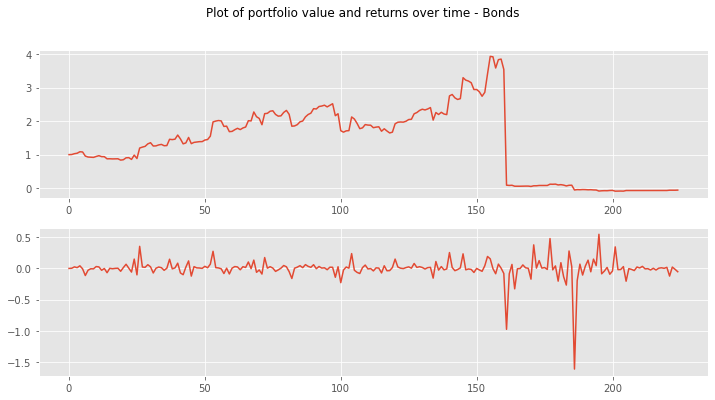

In [65]:
plot_performance(value, rtns, title="Plot of portfolio value and returns over time - Bonds")

In [66]:
perf_bench, value_bench, rtns_bench = strategy(X, window=5, horizon=1, benchmark=True)

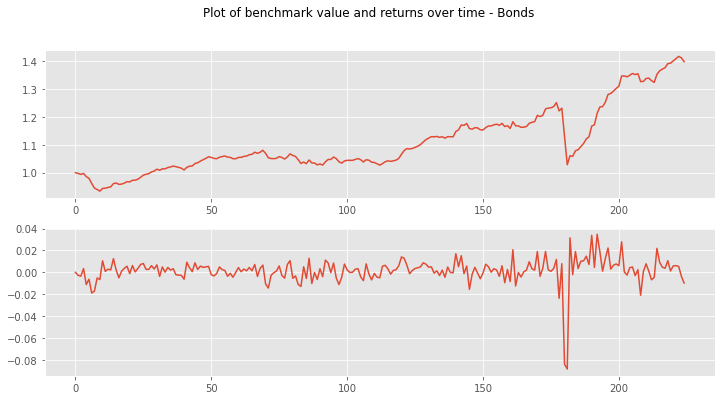

In [67]:
plot_performance(value_bench, rtns_bench, title="Plot of benchmark value and returns over time - Bonds")

In [76]:
X = equities.copy()

In [77]:
X.index = pd.to_datetime(X.index)

In [78]:
X = X.resample('W').sum()

In [79]:
X = X.replace(float('inf'), 0)

In [80]:
perf, value, rtns = strategy(X, window=30, horizon=1, benchmark=False)

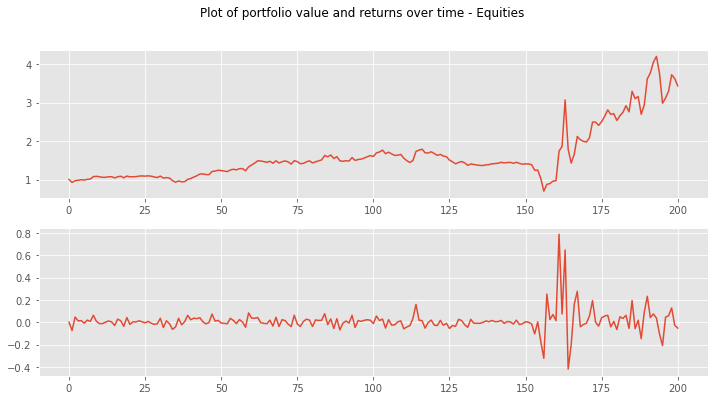

In [81]:
plot_performance(value, rtns, title="Plot of portfolio value and returns over time - Equities")

In [82]:
perf_bench, value_bench, rtns_bench = strategy(X, horizon=1, benchmark=True)

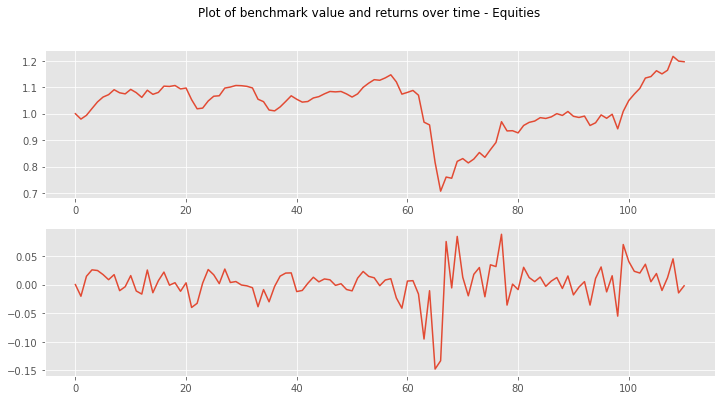

In [83]:
plot_performance(value_bench, rtns_bench, title="Plot of benchmark value and returns over time - Equities")

## MVP on the clusters

In [51]:
equities_clusters = [['Pakistan', 'Saudi Arabia', 'Qatar', 'Egypt', 'United Arab Emirates'],
                     ['Argentina', 'Greece', 'South Africa', 'Brazil', 'Colombia'],
                     ['Turkey'],
                     ['Thailand', 'Taiwan', 'Russia', 'China', 'Peru', 'Mexico', 'Malaysia', 'Korea', 'India', 'Poland', 'Philippines']]

In [52]:
bond_clusters = [['Bulgaria', 'China', 'Hungary', 'South Korea', 'Malaysia', 'Pakistan', 'Poland', 'Tunisia', 'Ukraine', 'Venezuela'],
                 ['Bolivia'],
                 ['Brazil', 'Colombia', 'Indonesia', 'Mexico', 'Panama', 'Peru', 'Philippines', 'Russia', 'Turkey', 'Uruguay', 'Vietnam', 'South Africa'],
                 ['Chile', 'Costa Rica', 'Dominican Republic', 'Egypt', 'Guatemala', 'Israel', 'Jamaica', 'Lebanon', 'Qatar', 'El Salvador', 'Trinidad & Tobago']
                ]

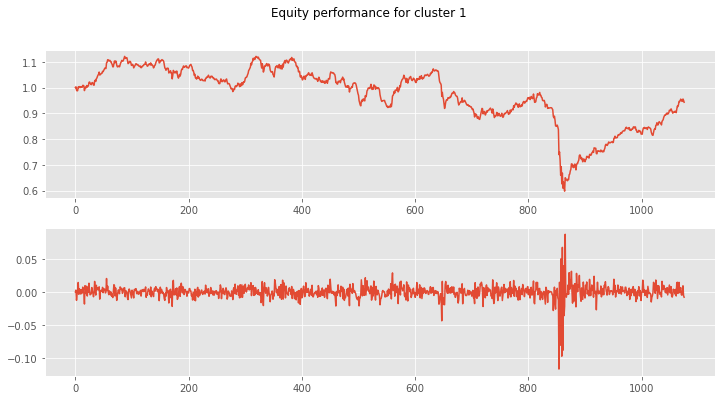

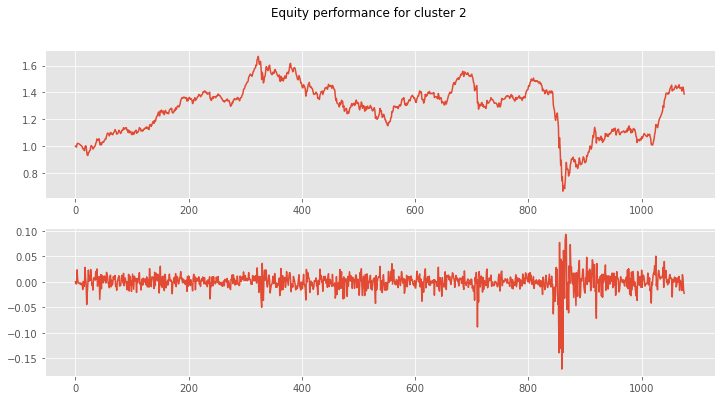

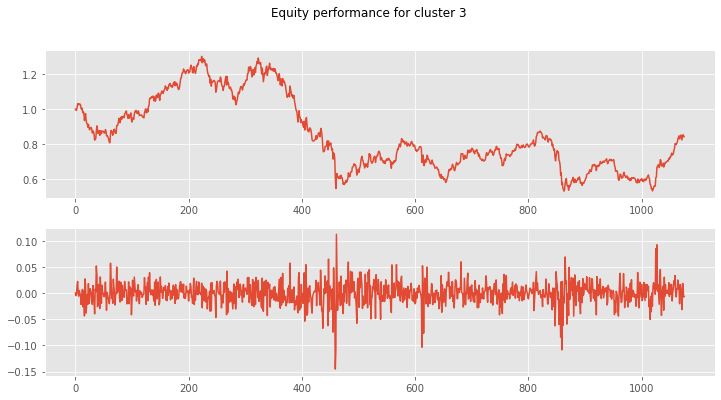

In [ ]:
for i in range(4):
    X = equities.loc[equities.index.isin(pd.date_range('2016-09-01', '2022-01-01')), equities_clusters[i]].copy()
    perf, value, rtns = strategy(X, window=30, horizon=1, benchmark=False)
    plot_performance(value, rtns, title="Equity performance for cluster "+str(i+1))